# Schallpegel Spitzensteinstrasse 18
Die Tamedia führte an ausgewählten Standorten Schallpegelmessungen durch. In diesem Notebook wird der Standort an der [Spitzensteinstrasse 18 in Seon (AG)](https://www.openstreetmap.org/way/155486293#map=19/47.34765/8.15262) ausgewertet. Zum Einsatz kamen zwei Messgeräte: ein Schallpegelmesser des unter anderem auf Lärmanalysen spezialisierten Unternehmens [Grolimund + Partner](https://www.gundp.ch/) sowie ein Eigenbaugerät, mit dem Tonschnipsel aufgezeichnet werden können. 

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datenimport-und--aufbereitung" data-toc-modified-id="Datenimport-und--aufbereitung-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Datenimport und -aufbereitung</a></span></li><li><span><a href="#Auswertungen" data-toc-modified-id="Auswertungen-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Auswertungen</a></span><ul class="toc-item"><li><span><a href="#Grundlegendes-zum-Datensatz" data-toc-modified-id="Grundlegendes-zum-Datensatz-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Grundlegendes zum Datensatz</a></span></li><li><span><a href="#Auswertungen-Schallpegel" data-toc-modified-id="Auswertungen-Schallpegel-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Auswertungen Schallpegel</a></span></li><li><span><a href="#Anzahl-Fahrzeuge" data-toc-modified-id="Anzahl-Fahrzeuge-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Anzahl Fahrzeuge</a></span></li><li><span><a href="#Test-des-Zählalgorithmus" data-toc-modified-id="Test-des-Zählalgorithmus-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Test des Zählalgorithmus</a></span></li><li><span><a href="#Berechnung-der-Anzahl-Autos" data-toc-modified-id="Berechnung-der-Anzahl-Autos-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Berechnung der Anzahl Autos</a></span></li><li><span><a href="#Auswertungen-zur-Anzahl-Fahrzeuge" data-toc-modified-id="Auswertungen-zur-Anzahl-Fahrzeuge-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Auswertungen zur Anzahl Fahrzeuge</a></span></li></ul></li><li><span><a href="#Eigenbausensor" data-toc-modified-id="Eigenbausensor-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Eigenbausensor</a></span></li></ul></div>

## Datenimport und -aufbereitung

In [1]:
# Importieren der nötigen Bibliotheken. 
import pandas as pd
from os import listdir
import numpy as np
from datetime import timedelta
from tqdm import tqdm
from detecta import detect_peaks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Importieren der Daten (Export von Grolimund + Partner). 
df = pd.read_csv('daten/EXPORT_A5941_LOGID_5_MPID_RAW', delimiter='\t')
df['datetime'] = pd.to_datetime(df['DATE(PST)'] + ' ' + df['TIME(PST)'])
df = df[['LEQ Spitzensteinstrasse 18 [MP 5]', 'datetime']]
df.set_index('datetime', inplace=True, drop=True)
df.columns = ['schallpegel']

# Werte, die vor oder während der Installation in Seon aufgezeichnet worden ist, werden ignoriert. 
df = df.loc['2020-07-17':]

# Der letzte Tag, der verzeichnet ist, ist nicht vollständig. Er wird ganz entfernt. 
df = df.loc[:str(df.index.max() - timedelta(days=1))[:-9]]

In [3]:
# Gemäss den Tonaufnahmen (siehe unter Eigenbausensor) wurden ein paar der lautesten Ereignisse 
# durch Kinderspiel oder Gespräche direkt vor dem Sensor sowie durch Stürme und Gewitter verursacht. 
# Die lautesten Autodurchfahrten, die zu hören waren, lagen bei 95 Dezibel. 
# Deshalb werden alle lauteren Werte ausgefiltert. 
df = df[df['schallpegel'] < 95]

# Der 1. und der 2. August werden ignoriert, da die Feuerwerke die Zahlen verfälschen. 
df = df.loc[:'2020-07-31'].append(df.loc['2020-08-03':])

In [4]:
# Bei Stürmen, Gewittern und anderem sehr lautem, stetigem Umgebungslärm sind die Messwerte nicht brauchbar. 
# Deshalb werden Werte nicht berücksichtigt, wenn der Schallpegel innert 10 Minuten nie unter 45dB sinkt.
print('Länge des Original-Datensatzes', len(df))
df_temp = df.resample('10min').min()
df_temp = df_temp[df_temp['schallpegel'] > 45]
df_temp.resample('s').ffill()
print(len(df_temp), 'Messungen werden entfernt')

df = df[~df.index.isin(df_temp.index)].dropna()
print('Länge des neuen Datensatzes', len(df))

Länge des Original-Datensatzes 4575280
85 Messungen werden entfernt
Länge des neuen Datensatzes 4575195


In [5]:
# Die logarithmischen Dezibel müssen für Berechnungen ins lineare Leistungsverhältnis umgerechnet werden.  
df['leistungsverhältnis'] = 10 ** (df['schallpegel'] / 10)

In [6]:
# Funktion zum Umrechnen des lineraren Liestungsverhältnis' in Dezibel. 
def lin2log(wert):
    return np.log10(wert) * 10

## Auswertungen

### Grundlegendes zum Datensatz

In [7]:
# Wann startete die Aufzeichnung? 
df.index.min()

Timestamp('2020-07-17 00:00:00')

In [8]:
# Bis wann dauert die Aufzeichnung?
df.index.max()

Timestamp('2020-09-09 23:59:59')

In [9]:
# Wie viele Tage dauerte die Aufzeichnung?
df.index.max() - df.index.min()

Timedelta('54 days 23:59:59')

In [10]:
# Wie viele Wochen dauerte die Aufzeichnung?
(df.index.max() - df.index.min()).days / 7

7.714285714285714

In [11]:
# Wie viele Messungen sind vorhanden? 
len(df)

4575195

In [12]:
# Wieviele Messungen sind pro Tag vorhanden? (Es sollten 24 * 60 * 60 = 86400 Werte pro Tag sein.)
df.resample('D').count()

,schallpegel,leistungsverhältnis
datetime,,
2020-07-17,86325,86325
2020-07-18,86325,86325
2020-07-19,86321,86321
2020-07-20,86327,86327
2020-07-21,86319,86319
2020-07-22,86327,86327
2020-07-23,86328,86328
2020-07-24,86326,86326
2020-07-25,86327,86327


### Auswertungen Schallpegel

In [13]:
# Wie hoch ist der durchschnittliche Schallpegel? 
lin2log(df['leistungsverhältnis'].mean())

57.443588615761136

In [14]:
# Wie hoch ist der durchschnittliche Schallpegel während des Tags? 
# (Definition von Tag und Nacht: https://www.admin.ch/opc/de/classified-compilation/19860372/index.html)
lin2log(df.between_time('06:00', '22:00')['leistungsverhältnis'].mean())

58.9617271778217

In [15]:
# Wie hoch ist das Stundenmittel in den Tagesstunden? 
lin2log(df.between_time('06:00', '22:00').resample('H')['leistungsverhältnis'].mean().mean())

58.77672928006614

In [16]:
# Wie hoch ist der durchschnittliche Schallpegel während der Nacht? 
# (Definition von Tag und Nacht: https://www.admin.ch/opc/de/classified-compilation/19860372/index.html)
lin2log(df.between_time('22:00', '06:00')['leistungsverhältnis'].mean())

49.510371913321606

In [17]:
# Wie hoch ist das Stundenmittel in den Nachtstunden? 
lin2log(df.between_time('22:00', '06:00').resample('H')['leistungsverhältnis'].mean().mean())

50.570139795143774

In [18]:
# Wie laut ist es zwischen 17 und 18 Uhr? 
lin2log(df.between_time('17:00', '18:00')['leistungsverhältnis'].mean())

60.83054971720163

In [19]:
# Wie laut ist es zwischen 3 und 4 Uhr? 
lin2log(df.between_time('03:00', '04:00')['leistungsverhältnis'].mean())

43.12943885203594

In [20]:
# Wann wurden die höchsten Pegel registriert? 
df.sort_values(by= 'schallpegel', ascending=False).head()

,schallpegel,leistungsverhältnis
datetime,,
2020-08-08 19:59:11,94.4288,2.772554e+09
2020-08-08 19:59:12,94.0288,2.528599e+09
2020-08-16 23:44:32,94.0288,2.528599e+09
2020-08-26 15:12:08,93.8288,2.414794e+09
2020-08-08 18:22:33,93.8288,2.414794e+09


In [21]:
# Wie hoch ist der minimale Schallpegel? 
df['schallpegel'].min()

30.2288

In [22]:
# Wann wurde der tiefste Pegel registriert? 
df[df['schallpegel'] == df['schallpegel'].min()]

,schallpegel,leistungsverhältnis
datetime,,
2020-07-17 14:25:22,30.2288,1054.095599


In [23]:
# Wie hoch ist das "Grundrauschen"?
df['schallpegel'].quantile(.25)

35.8288

In [24]:
# Wie hoch liegt der Wert des 0.75 Perzentils?
df['schallpegel'].quantile(.75)

51.0288

In [25]:
# Bei wievielen Prozent der Messungen liegt der Schallpegel über 60 Dezibel? 
(100 * df[df['schallpegel'] >= 60].count() / df.count())['schallpegel']

10.653819126835032

In [26]:
# Bei wievielen Prozent der Messungen liegt der Schallpegel über 70 Dezibel? 
(100 * df[df['schallpegel'] >= 70].count() / df.count())['schallpegel']

0.6592724463110315

In [27]:
# Wie oft liegt der Stundenmittelwert während des Tags über dem Grenzwert von 60dB?
df_temp = df.between_time('06:00', '22:00')
df_temp = df_temp.resample('H')[['leistungsverhältnis']].mean()
df_temp['schallpegel'] = df['leistungsverhältnis'].apply(lin2log)
df_temp = df_temp[df_temp['schallpegel'] > 60]
print('Stunden insgesamt:', len(df.resample('H').sum()))
print('Stunden mit Mittelwerten über dem Grenzwert:', len(df_temp))
print('Anteil in Prozent:', 100 * len(df_temp) / len(df.resample('H').sum()))

Stunden insgesamt: 1320
Stunden mit Mittelwerten über dem Grenzwert: 119
Anteil in Prozent: 9.015151515151516


In [28]:
# An wievielen Tagen liegt der Stundenmittelwert während des Tags durchschnittlich über 60dB?
df_temp = df.between_time('06:00', '22:00').resample('H')[['leistungsverhältnis']].mean()
df_temp = df_temp.resample('D').mean().apply(lin2log)
df_temp.columns = ['schallpegel']
print('Tage insgesamt:', len(df.resample('d').sum()))
print('Tage mit Stundenmitteln, die durchschnittlich über 60dB liegen:', len(df_temp[df_temp['schallpegel'] > 60]))
print('In Prozent:', 100 * len(df_temp[df_temp['schallpegel'] > 60]) / len(df.resample('d').sum()))

Tage insgesamt: 55
Tage mit Stundenmitteln, die durchschnittlich über 60dB liegen: 6
In Prozent: 10.909090909090908


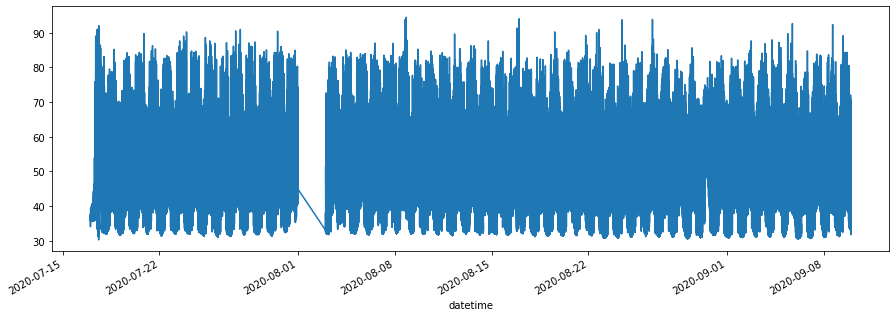

In [29]:
# Wie sieht der Schallpegelverlauf aus? 
df['schallpegel'].plot(figsize=[15,5])

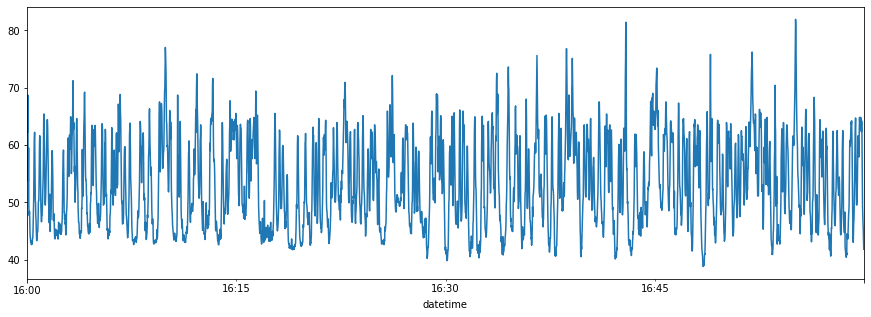

In [30]:
# Wie sieht der Schallpegelverlauf einer bestimmten Stunde aus? 
df_test = df.loc['2020-08-21 16']['schallpegel']
df_test.plot(figsize=[15,5])

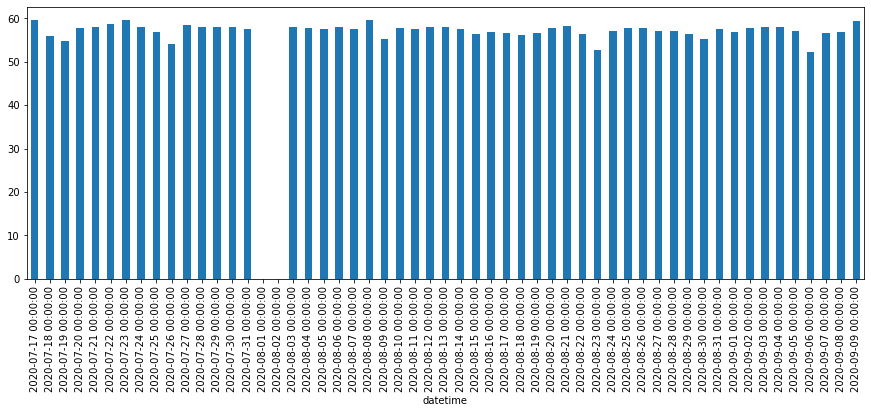

In [31]:
# Gibts Unterschiede zwischen den einzelnen Tagen? Die Grafik. 
fig, ax = plt.subplots()
df['leistungsverhältnis'].resample('D').mean().apply(lin2log).plot(kind='bar', figsize=[15,5], ax=ax)

In [32]:
# Gibts Unterschiede zwischen den einzelnen Wochentagen? 
df_temp = df.copy()
df_temp['wochentag'] = df_temp.index.dayofweek
wochentage = {0: 'Montag', 1: 'Dienstag', 0: 'Montag', 2: 'Mittwoch', 3: 'Donnerstag', 4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'}
for i in range(7):
    print(wochentage[i] + ':', lin2log(df_temp[df_temp['wochentag'] == i]['leistungsverhältnis'].mean()))

Montag: 57.56482670449846
Dienstag: 57.45335509420768
Mittwoch: 58.05319796231355
Donnerstag: 58.14732087771327
Freitag: 58.01568770558699
Samstag: 57.092403236308
Sonntag: 54.71634044500252


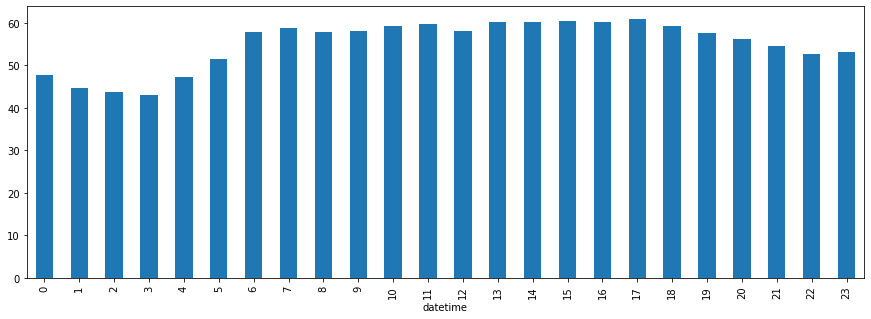

In [33]:
# Wie sieht ein durchschnittlicher Tag aus? 
df.groupby(by=df.index.hour)['leistungsverhältnis'].mean().apply(lin2log).plot(kind='bar', figsize=[15,5])

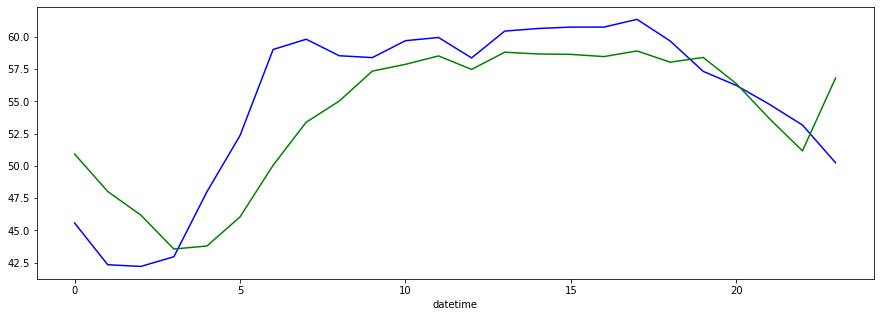

In [34]:
# Samstagsverlauf mit Wochentagsverlauf vergleichen. 
df_temp = df.copy()
df_temp['wochentag'] = df_temp.index
df_temp['wochentag'] = df_temp['wochentag'].apply(lambda x: wochentage[x.dayofweek])

df_temp1 = df_temp[(df_temp['wochentag'] != 'Samstag') & (df_temp['wochentag'] != 'Sonntag')]
df_temp2 = df_temp[(df_temp['wochentag'] == 'Samstag') | (df_temp['wochentag'] == 'Sonntag')]

fig, ax = plt.subplots(figsize=[15,5])
df_temp1.groupby(by=df_temp1.index.hour)['leistungsverhältnis'].mean().apply(lin2log).plot(ax=ax, color='blue')
df_temp2.groupby(by=df_temp2.index.hour)['leistungsverhältnis'].mean().apply(lin2log).plot(ax=ax, color='green')

In [35]:
# Wie laut ist es durchschnittlich während der Arbeitswoche. 
df_temp1['schallpegel'].mean()

45.120079916998456

In [36]:
# Wie laut ist es durchschnittlich während des Wochenendes. 
df_temp2['schallpegel'].mean()

42.96485607557066

In [37]:
# Wie oft werden Schallpegel von über 70 Dezibel verzeichnet? 
df[df['schallpegel'] > 70]['schallpegel'].resample('D').count().replace(0, np.NaN).mean()

569.1132075471698

In [38]:
# Importieren der Maximal-Lärmwerte, die vom Sensor auch aufgezeichnet werden.  
df_max = pd.read_csv('daten/EXPORT_A5941_LOGID_5_MPID_RAW', delimiter='\t')
df_max['datetime'] = pd.to_datetime(df_max['DATE(PST)'] + ' ' + df_max['TIME(PST)'])
df_max = df_max[['LMax', 'datetime']]
df_max.set_index('datetime', inplace=True, drop=True)
df_max.columns = ['schallpegel']

# Werte, die vor oder während der Installation in Seon aufgezeichnet worden ist, werden ignoriert. 
df_max = df_max.loc['2020-07-17':]

# Der letzte Tag, der verzeichnet ist, ist nicht vollständig. Er wird ganz entfernt. 
df_max = df_max.loc[:str(df_max.index.max() - timedelta(days=1))[:-9]]

# Die logarithmischen Dezibel müssen für Berechnungen ins lineare Leistungsverhältnis umgerechnet werden.  
df_max['leistungsverhältnis'] = 10 ** (df_max['schallpegel'] / 10)

In [39]:
# Wie stark verändern wenige Spitzenwerte den Mittelwert? 
df_temp = df_max.loc['2020-09-09 05:55': '2020-09-09 06:00']
print('Minimalwert:', df_temp['schallpegel'].min()) 
print('Maximalwert:', df_temp['schallpegel'].max())
print('Durchschnitt:', df_temp['schallpegel'].mean())
print('Durchschnitt ohne die Schallspitzen:', df_temp[df_temp['schallpegel'] < df_temp['schallpegel'].mean()]['schallpegel'].mean())

Minimalwert: 33.8288
Maximalwert: 75.3288
Durchschnitt: 40.686577777777785
Durchschnitt ohne die Schallspitzen: 36.20078443579767


### Anzahl Fahrzeuge
Gemessen wurde in unserem Versuch lediglich der Schalldruck. Am betreffenden Ort ist davon auszugehen, dass die allermeisten höheren Werte von vorbeifahrenden Autos verursacht wurden. Aus den Schallpegeln lässt sich deshalb die ungefähre Anzahl Fahrzeuge errechnen. Dabei handelt es sich lediglich um eine grobe Schätzung, da der durch Fahrzeuge verursachten Schall nicht von anderem Schall unterschieden werden kann. 

In den Berechnungen gehen wir davon aus, dass durch ein Fahrzeug 50 oder mehr Dezibel Lärm verursacht wird. Um einzelne Fahrzeuge nicht mehrfach zu zählen, wird pro 2 Sekunden höchstens eine Durchfahrt registriert.

In [40]:
def autozähler(df_temp, illu):
    peaks = detect_peaks(df_temp['schallpegel'].resample('2s').median(), mpd=3, mph=50, show=illu, edge='rising')
    return len(peaks)

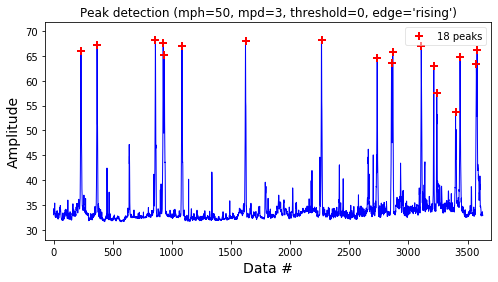

18

In [41]:
# Beispiel: Die Anzahl Autos wird gezählt. 
autozähler(df.loc['2020-07-19 04:00': '2020-07-19 06:00':], True)

### Test des Zählalgorithmus
Um die Realität möglichst genau abzubilden, sollen die Parameter mit einigen manuellen Zählungen verglichen werden. Dazu werden mit dem Sensor 2 Aufnahmen in der Länge von 10 Minuten gemacht. Anschliessend wird ausgezählt, wie viele Fahrzeuge darauf akustisch zu unterscheiden sind.   

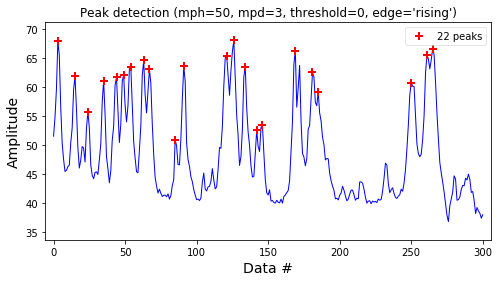

22

In [42]:
# Bei der manuellen Zählung in diesem Testzeitraum fuhren 24 Fahrzeuge vorbei. 
# Wie viele werden mit dem Algorithmus detektiert?  
df_test = pd.read_csv('daten/algotest_2020-09-09_03-30.csv', parse_dates=True, index_col='Time')
df_test = df_test.loc['2020-09-09 08:31:26': '2020-09-09 08:41:26']
df_test = df_test[['LEQ Spitzensteinstrasse 18 [MP 5]']]
df_test.columns = ['schallpegel']
autozähler(df_test, True)

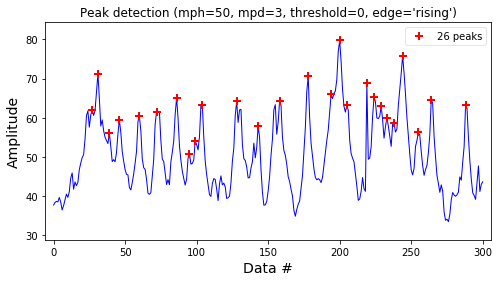

26

In [43]:
# Bei der manuellen Zählung in diesem Testzeitraum fuhren 25 Fahrzeuge vorbei. 
# Wie viele werden mit dem Algorithmus detektiert? 
df_test = pd.read_csv('daten/algotest_2020-09-09_03-30.csv', parse_dates=True, index_col='Time')
df_test = df_test.loc['2020-09-09 08:41:28': '2020-09-09 08:51:28']
df_test = df_test[['LEQ Spitzensteinstrasse 18 [MP 5]']]
df_test.columns = ['schallpegel']
autozähler(df_test, True)

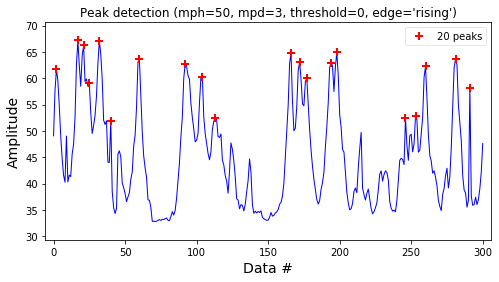

20

In [44]:
# Bei der manuellen Zählung in diesem Testzeitraum fuhren 20 Fahrzeuge vorbei. 
# Wie viele werden mit dem Algorithmus detektiert? 
df_test = pd.read_csv('daten/algotest_2020-09-09_03-30.csv', parse_dates=True, index_col='Time')
df_test = df_test.loc['2020-09-09 08:51:30': '2020-09-09 09:01:30']
df_test = df_test[['LEQ Spitzensteinstrasse 18 [MP 5]']]
df_test.columns = ['schallpegel']
autozähler(df_test, True)

### Berechnung der Anzahl Autos

In [45]:
n = 0
autodict = dict()
daterange = pd.date_range(df.index.min(), df.index.max(), freq='H')
for d in tqdm(daterange): 
    n += 1
    autodict[d] = autozähler(df.loc[str(d): str(daterange[n])].iloc[:-1], False)
    if n == len(daterange) -1 :
        break

df_auto = pd.DataFrame.from_dict(autodict, orient='index')
df_auto['wochentag'] = df_auto.index.dayofweek
df_auto['wochentag'] = df_auto['wochentag'].apply(lambda x: wochentage[x])
df_auto.columns = ['anz_autos', 'wochentag']

# Die Daten einzelner Tage wurden wegen Datenproblemen (z.B. 1. August) herausgefiltert. 
# Die 0 werden hier durch NaN ersetzt, so dass sie bei den Auswertungen nicht berüchsichtigt werden.  
df_auto['anz_autos'] = df_auto['anz_autos'].replace(0, np.NaN)

100%|█████████▉| 1318/1320 [00:05<00:00, 262.93it/s]


### Auswertungen zur Anzahl Fahrzeuge

In [46]:
# In welchen Stunden gab es am meisten Verkehr? 
df_auto.sort_values(by='anz_autos', ascending=False).head(10)

,anz_autos,wochentag
2020-07-17 14:00:00,288.0,Freitag
2020-08-30 12:00:00,280.0,Sonntag
2020-08-30 13:00:00,280.0,Sonntag
2020-08-30 11:00:00,259.0,Sonntag
2020-08-15 17:00:00,258.0,Samstag
2020-08-30 14:00:00,249.0,Sonntag
2020-09-09 17:00:00,240.0,Mittwoch
2020-08-12 17:00:00,239.0,Mittwoch
2020-09-04 17:00:00,233.0,Freitag
2020-08-19 17:00:00,231.0,Mittwoch


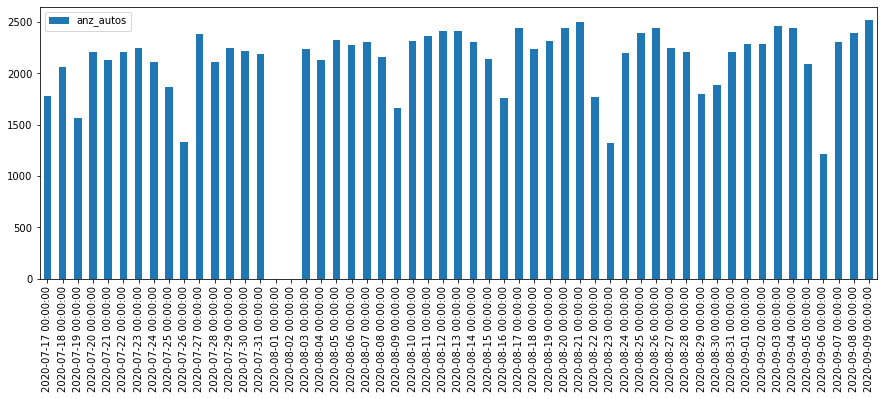

In [47]:
# Grafik: Wie viele Fahrzeuge werden pro Tag verzeichnet. 
df_auto[['anz_autos']].resample('D').sum().plot(kind='bar', figsize=[15,5])

In [48]:
# Wie gross ist das Verkehrsaufkommen an einem durchschnittlichen Tag? 
df_temp = df_auto.resample('D').sum()
df_temp['anz_autos'] = df_temp['anz_autos'].replace(0, np.NaN)
df_temp.mean()

anz_autos    2146.981132
dtype: float64

In [49]:
# Wie viele Fahrzeuge fahren durchschnittlich an Wochentagen durch? 
df_temp = df_auto[(df_auto['wochentag'] != 'Samstag') & (df_auto['wochentag'] != 'Sonntag')]
df_temp = df_temp.resample('D')[['anz_autos']].sum()
df_temp['anz_autos'] = df_temp['anz_autos'].replace(0, np.NaN)
df_temp.mean()

anz_autos    2286.717949
dtype: float64

In [50]:
# Wie viele Fahrzeuge fahren durchschnittlich am Wochenende durch? 
df_temp = df_auto[(df_auto['wochentag'] == 'Samstag') | (df_auto['wochentag'] == 'Sonntag')]
df_temp = df_temp.resample('D')[['anz_autos']].sum()
df_temp['anz_autos'] = df_temp['anz_autos'].replace(0, np.NaN)
df_temp.mean()

anz_autos    1757.714286
dtype: float64

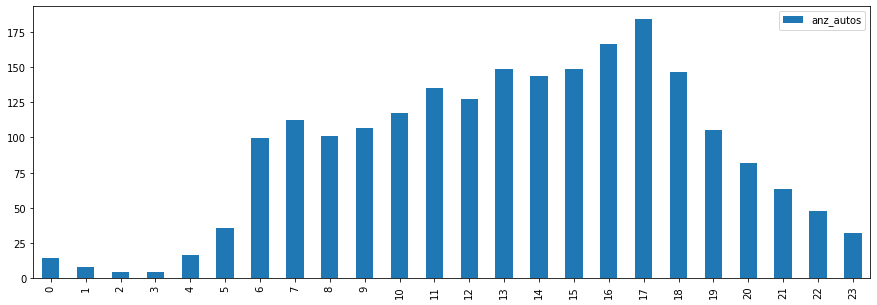

In [51]:
# Wie sieht ein durchschnittlicher Tagesverlauf bei der Anzahl Fahrzeugen aus?
df_auto.groupby(by=df_auto.index.hour).mean().sort_index(ascending=True).plot(kind='bar', figsize=[15,5])

In [52]:
# Wie häufig fährt in der "Rushhour" ein Auto vorbei (Anzahl Sekunden)? 
60 * 60 / df_auto.groupby(by=df_auto.index.hour).mean()['anz_autos'].max()

19.555191144819105

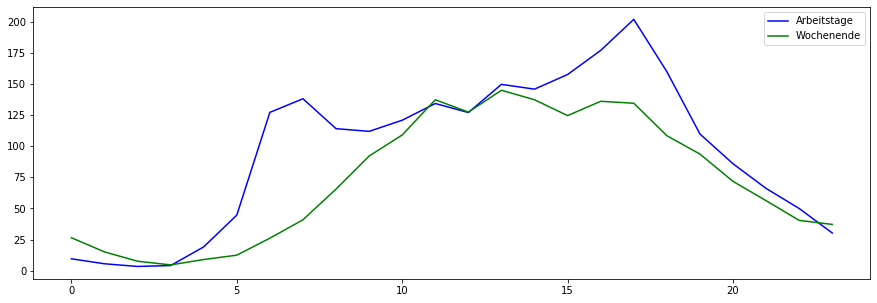

In [53]:
# Wie sieht ein durchschnittlicher Tagesverlauf bei der Anzahl Fahrzeugen an Wochentagen und Wochenenden aus?
fig, ax = plt.subplots(figsize=[15,5])

# Verlauf unter der Woche.
df_temp = df_auto[(df_auto['wochentag'] != 'Samstag') & (df_auto['wochentag'] != 'Sonntag')]
df_temp.groupby(by=df_temp.index.hour).mean().sort_index(ascending=True).plot(color='blue', label='Arbeitstage', ax=ax)

# Verlauf am Wochenende. 
df_temp = df_auto[(df_auto['wochentag'] == 'Samstag') | (df_auto['wochentag'] == 'Sonntag')]
df_temp.groupby(by=df_temp.index.hour).mean().sort_index(ascending=True).plot(color='green', label='Wochenende', ax=ax)
ax.legend(['Arbeitstage', 'Wochenende'])
plt.show()

In [54]:
# Wie viele Autos sind in der gesamten Messperiode vorbeigefahren? 
df_auto['anz_autos'].sum()

113790.0

## Eigenbausensor
Der Eigenbausensor besteht aus einem Raspberry Pi mit Mikrofon-Hat. Das Gerät zeichnet den Schallpegel auf. Überschreitet dieser einen vordefinierten Wert, wird eine Tonaufzeichnung gemacht. Anhand dieser Fünf-Sekunden-Tonschnipsel kann kontrolliert werden, ob es sich bei hohen Schallpegeln, die der erste Sensor registriert hat, wirklich um vorbeifahrende Autos gehandelt hat. Einzelne Tonaufzeichnungen werden zudem für die Online-Berichterstattung verwendet. Da das Eigenbaugerät über keinen genügend hohen Windschutz verfügt und das Mikrofon nicht geeicht wird, wird stets mit den Schallpegelwerten des Profisensors gearbeitet. 